Calibrating gyro...
Gyro bias: [ 33.36777778 -36.59818182  37.48949495]


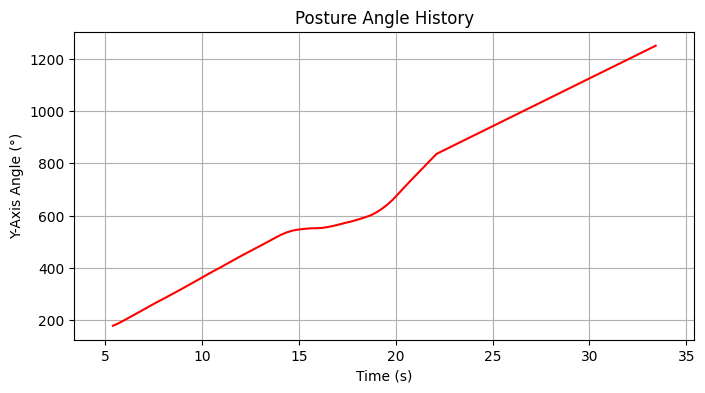

In [1]:
import serial
import time
import math
import numpy as np
import tensorflow as tf
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from collections import deque

# === Configuration ===
SERIAL_PORT = "COM5"
BAUD_RATE = 9600
SEQUENCE_LENGTH = 30
UPDATE_INTERVAL = 100  # ms for GUI updates
CALIBRATION_SAMPLES = 100  # Samples for gyro calibration

class PostureMonitorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Posture Analysis System")
        
        # Initialize serial connection
        self.ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1)
        time.sleep(2)  # Allow Arduino to initialize
        
        # Calibration variables
        self.gyro_bias = [0, 0, 0]
        self.calibrate_gyro()
        
        # Data buffers
        self.angle_buffer = deque(maxlen=SEQUENCE_LENGTH)
        self.time_history = deque(maxlen=100)
        self.angle_history = deque(maxlen=100)
        self.angles = [0.0, 0.0, 0.0]  # [x, y, z]
        self.prev_time = time.time()
        self.start_time = time.time()
        
        # Load ML model
        self.model = tf.keras.models.load_model("lstm_posture_model.h5")

        # GUI Setup
        self.create_widgets()
        self.running = True
        self.update_data()
        
    def calibrate_gyro(self):
        print("Calibrating gyro...")
        samples = []
        for _ in range(CALIBRATION_SAMPLES):
            data = self.read_serial_data()
            if data:
                samples.append([data['gyro_x'], data['gyro_y'], data['gyro_z']])
            time.sleep(0.01)
        
        if samples:
            self.gyro_bias = np.mean(samples, axis=0)
        print(f"Gyro bias: {self.gyro_bias}")

    def read_serial_data(self):
        try:
            line = self.ser.readline().decode('utf-8').strip()
            if line.startswith("X:"):
                parts = line.split('|')
                return {
                    'gyro_x': float(parts[0].split(':')[1].strip()) - self.gyro_bias[0],
                    'gyro_y': float(parts[1].split(':')[1].strip()) - self.gyro_bias[1],
                    'gyro_z': float(parts[2].split(':')[1].strip()) - self.gyro_bias[2]
                }
        except Exception as e:
            print(f"Serial error: {e}")
        return None

    def create_widgets(self):
        main_frame = ttk.Frame(self.root, padding=10)
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Real-time display
        self.status_label = ttk.Label(main_frame, text="Posture: Calculating...", font=('Helvetica', 14))
        self.status_label.grid(row=0, column=0, columnspan=2)
        
        self.angle_label = ttk.Label(main_frame, text="Angles: X: 0.00° | Y: 0.00° | Z: 0.00°", font=('Helvetica', 12))
        self.angle_label.grid(row=1, column=0, columnspan=2)
        
        # Analysis plot
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.line, = self.ax.plot([], [], 'r-')
        self.ax.set_title("Posture Angle History")
        self.ax.set_ylabel("Y-Axis Angle (°)")
        self.ax.set_xlabel("Time (s)")
        self.ax.grid(True)
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=main_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().grid(row=2, column=0, columnspan=2)
        
        # Statistics
        stats_frame = ttk.LabelFrame(main_frame, text="Posture Statistics", padding=10)
        stats_frame.grid(row=3, column=0, columnspan=2, pady=10, sticky='ew')
        
        self.good_posture_label = ttk.Label(stats_frame, text="Good Posture: 0%")
        self.good_posture_label.grid(row=0, column=0, padx=5)
        
        self.bad_posture_label = ttk.Label(stats_frame, text="Bad Posture: 0%")
        self.bad_posture_label.grid(row=0, column=1, padx=5)
        
        # Control buttons
        self.reset_btn = ttk.Button(main_frame, text="Reset", command=self.reset_system)
        self.reset_btn.grid(row=4, column=0, pady=10)
        
        self.quit_btn = ttk.Button(main_frame, text="Quit", command=self.cleanup)
        self.quit_btn.grid(row=4, column=1, pady=10)
        
        # Initialize statistics
        self.total_samples = 0
        self.good_samples = 0

    def update_angles(self, data):
        current_time = time.time()
        dt = current_time - self.prev_time
        self.prev_time = current_time
        
        # Integrate gyro data (convert from deg/s to degrees)
        self.angles[0] += data['gyro_x'] * dt
        self.angles[1] += data['gyro_y'] * dt
        self.angles[2] += data['gyro_z'] * dt
        
        # Store history for plotting
        self.time_history.append(current_time - self.start_time)
        self.angle_history.append(self.angles[1])

    def make_prediction(self):
        self.angle_buffer.append(self.angles)
        
        if len(self.angle_buffer) == SEQUENCE_LENGTH:
            input_sequence = np.array(self.angle_buffer).reshape(1, SEQUENCE_LENGTH, 3)
            prediction = self.model.predict(input_sequence, verbose=0)[0][0]
            return prediction
        return 0.5  # Neutral value

    def update_plot(self):
        if len(self.time_history) > 1:
            self.line.set_data(self.time_history, self.angle_history)
            self.ax.relim()
            self.ax.autoscale_view(True, True, True)
            self.ax.set_xlim(left=max(0, self.time_history[-1]-30), right=self.time_history[-1]+2)
            self.canvas.draw()

    def update_gui(self, prediction):
        # Update labels
        status = "GOOD POSTURE" if prediction > 0.7 else "BAD POSTURE"
        color = "green" if prediction > 0.7 else "red"
        self.status_label.config(text=f"Posture: {status} ({prediction*100:.1f}%)", foreground=color)
        self.angle_label.config(text=f"Angles: X: {self.angles[0]:.2f}° | Y: {self.angles[1]:.2f}° | Z: {self.angles[2]:.2f}°")
        
        # Update statistics
        self.total_samples += 1
        if prediction > 0.7:
            self.good_samples += 1
            
        good_percent = (self.good_samples / self.total_samples * 100) if self.total_samples > 0 else 0
        self.good_posture_label.config(text=f"Good Posture: {good_percent:.1f}%")
        self.bad_posture_label.config(text=f"Bad Posture: {100 - good_percent:.1f}%")
        
    def reset_system(self):
        self.angles = [0.0, 0.0, 0.0]
        self.time_history.clear()
        self.angle_history.clear()
        self.angle_buffer.clear()
        self.total_samples = 0
        self.good_samples = 0
        self.start_time = time.time()
        self.prev_time = time.time()
        
    def update_data(self):
        if not self.running:
            return
            
        data = self.read_serial_data()
        if data:
            self.update_angles(data)
            prediction = self.make_prediction()
            self.update_gui(prediction)
            self.update_plot()
            
        self.root.after(UPDATE_INTERVAL, self.update_data)
        
    def cleanup(self):
        self.running = False
        self.ser.close()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = PostureMonitorApp(root)
    root.mainloop()
